In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import chisquare

### Create a function that plots the distribution of the digits of a given array compared to the distribution of Benford's law

In [2]:
# distribution according to Benford's law
benford = np.array([30.1, 17.6,12.5,9.7,7.9,6.7,5.8,5.1,4.6])

The following function takes a vector w as input and returns 
- *perc*: an array of length 9 with the percentage of the appeareance of the i-th digit in w at the i-th position
- *RMSE*: the root mean squared error, measuring how far *perc* is from Benford's distribution

In [2]:
def Benford(w):
    
    # if a list is given, turn it into an numpy array
    if type(w) is not np.ndarray: w = w.to_numpy()
        
    # extract the first non zero digit
    for j in range(len(w)):
        # if the number is zero, skip
        if w[j]==0: continue
        u = str(w[j])
        # until there are zeros, skip to the next digit
        while (u[0]=='0') or (u[0]=='.'): # skip also '.' in case the number is 0.04274 for example
            u = u[1:]
        
        w[j]=int(u[0])
    
    # now w is an array with integers from 0. to 9.
    
    # count the frequency of each digit as percentage 
    count = pd.Series(w).value_counts(normalize=True).sort_index()
    
    # it might be that a digit is missing. put zero instead.
    perc = pd.DataFrame(count)
    perc.index= [int(x) for x in perc.index]
    zeros = pd.DataFrame({'zero': np.zeros(10)},np.arange(0,10))
    join_df = perc.join(zeros,how='outer').fillna(0)
    
    perc = list((join_df[0]+join_df['zero'])*100)[1:10] # EXCLUDE ZERO!
      
    # calculate root mean squared error
    RMSE = mean_squared_error(benford,perc, squared= False)/(benford.max()-benford.min())
 
    return perc, RMSE

The next function plots the percentages of a given vector compared to Benford's distribution

In [36]:
def Benford_print(w, name= 'Input'):
    perc, RMSE = Benford(w)
    
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(1,10))
    plt.scatter(np.arange(1,10), perc, label = 'Naive')
    plt.scatter(np.arange(1,10), benford, color = 'r', label = 'Benford')
    plt.title('Comparing '+name+' and Benford distributions')
    plt.ylabel('Percentage')
    plt.xlabel('Digit')
    ax.legend([name,'Benford'])
    ax.grid(linestyle='--', linewidth=0.5)
    plt.show()
    
    print('RMSE: ', RMSE,'\n\n')

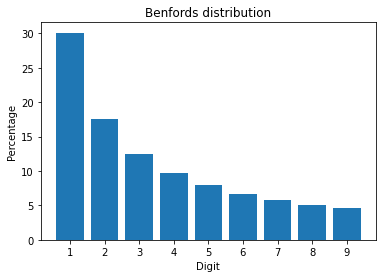

In [25]:
plt.bar(np.arange(1,10), benford, tick_label = np.arange(1,10))
plt.title('Benfords distribution')
plt.ylabel('Percentage')
plt.xlabel('Digit')
plt.show()

The distribution of first digits, according to Benford's law. Each bar represents a digit, and the height of the bar is the percentage of numbers that start with that digit.

### Let's try it on a random array

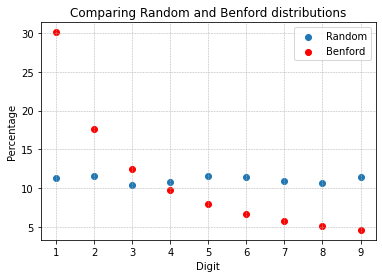

RMSE:  0.30310612714337315 




In [37]:
w = np.random.rand(5674)
Benford_print(w, 'Random')

Let's generate a number of random vectors and see the average RMSE and percentages. We expect that the digits are equally distributed with 11.11% of appearence each.

In [38]:
for k in range(100):
    length = np.random.randint(1,10000)
    perc, RMSE = Benford(np.random.rand(length))
    if k ==0: 
        RMSE_ = RMSE
        perc_ = np.array([perc])
    else:
        RMSE_ = np.append(RMSE_,RMSE)
        perc_ = np.append(perc_,np.array([perc]), axis =0)
    
print('Average RMSE:', RMSE_.mean())
print('Average percentages:', perc_.mean(axis=0))

Average RMSE: 0.30532127347571125
Average percentages: [11.10356778 11.10480856 11.19736392 11.24971436 11.06384233 11.02951913
 10.97234907 11.16354382 11.11529103]


### The shape of the Benford distribution reminds me the exponential one. Let's compare them.

In [14]:
from scipy.stats import expon
data_expon = expon.rvs(scale=1,loc=0,size=1000)

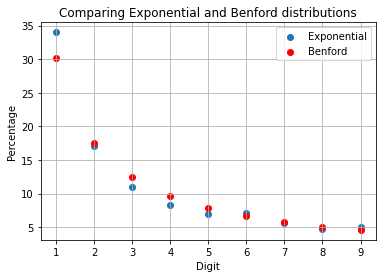

RMSE:  0.059931468686785075 




In [15]:
Benford_print(data_expon, 'Exponential')

In [19]:
# again, let's find an average RMSE

for k in range(1000):
    length = np.random.randint(1,1000)
    perc, RMSE = Benford(expon.rvs(scale=1,loc=0,size=length))
    if k ==0: 
        RMSE_ex = RMSE
        perc_ex = np.array([perc])
    else:
        RMSE_ex = np.append(RMSE_ex,RMSE)
        perc_ex = np.append(perc_ex,np.array([perc]), axis =0)
    
print('Average RMSE:', RMSE_ex.mean())
print('Average percentages:', perc_ex.mean(axis=0))

Average RMSE: 0.08226569726159617
Average percentages: [32.96584629 17.41979919 11.31320991  8.56442581  7.17090143  6.36969767
  5.87815393  5.32258046  4.99538533]


Indeed, we can see that the average RMSE here is quite low and the percentages remind the one of Benford's distribution

### Now it's time to take some real dataset and see whether Benford's law holds

- First, we take the Fraud Detection on Bank Payments dataset from Kaggle
(https://www.kaggle.com/turkayavci/fraud-detection-on-bank-payments/data)
and consider the column with the amount of the purchase 

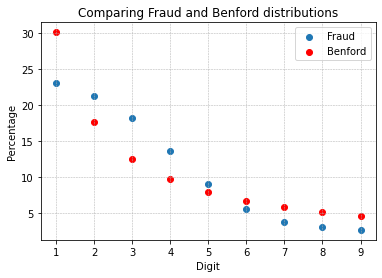

RMSE:  0.14664955548014777 




In [40]:
df = pd.read_csv('datasets/fraud_detection_bank_dataset.csv')

amount = df['amount']
Benford_print(amount, 'Fraud')

We can actually see that the lower digits appear more often than the others, but the RMSE tell us that the distributions don't agree.

- Consider now the MusicNet dataset, a collection of 330 freely-licensed classical music recordings
(https://www.kaggle.com/imsparsh/musicnet-dataset?select=musicnet_metadata.csv)
and its column with the duration of the recording in seconds.

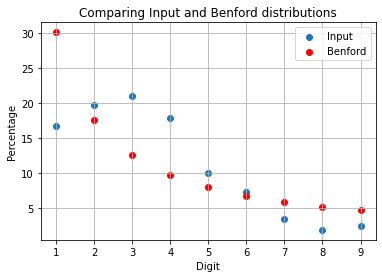

RMSE:  0.2441275146594341 




In [23]:
df_1 = pd.read_csv('musicnet_metadata.csv')

sec = df_1['seconds']
Benford_print(sec)

Here unfortunately the result is even worse... 

- Let's turn to other strtistics, the Trending YouTube Video Statistics
(https://www.kaggle.com/datasnaek/youtube-new?select=USvideos.csv).
 Here we can consider different columns, such as 'views', 'likes', 'dislikes', 'comment_count'

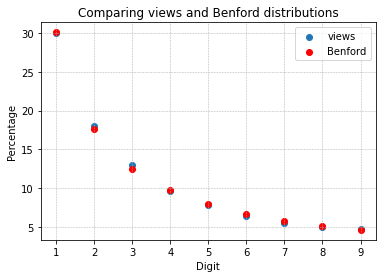

RMSE:  0.00928091004746307 




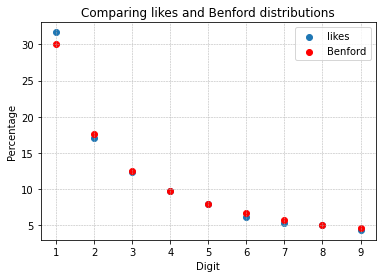

RMSE:  0.023828268477435136 




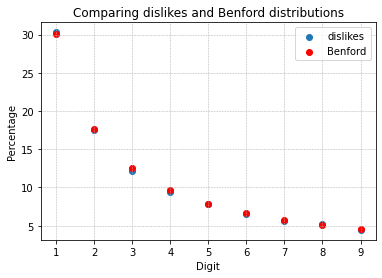

RMSE:  0.0078072070125858066 




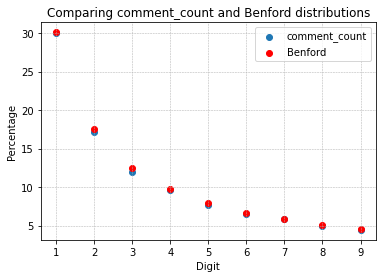

RMSE:  0.010653841084520414 




In [41]:
dfYT = pd.read_csv('datasets/USvideos.csv')

attr = ['views', 'likes', 
        'dislikes', 'comment_count']

dfYT_copy= dfYT.copy()
for col in attr:
    Benford_print(dfYT_copy[col],col)

WOW!! I don't need to explain the results... it fits perfectly :) 
We could try to study the outliars and see what they have in common. 

- Next, I'd like to look at some measures. For example, take the 
Body Measurements Dataset from Kaggle
(https://www.kaggle.com/saurabhshahane/body-measurements-dataset)

In [43]:
df_body = pd.read_csv('datasets/Body Measurements _ original_CSV.csv')

df_body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             715 non-null    float64
 1   Age                716 non-null    int64  
 2   HeadCircumference  716 non-null    int64  
 3   ShoulderWidth      716 non-null    int64  
 4   ChestWidth         716 non-null    int64  
 5   Belly              716 non-null    int64  
 6   Waist              716 non-null    int64  
 7   Hips               716 non-null    int64  
 8   ArmLength          716 non-null    int64  
 9   ShoulderToWaist    716 non-null    int64  
 10  WaistToKnee        716 non-null    int64  
 11  LegLength          716 non-null    int64  
 12  TotalHeight        716 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 72.8 KB


In [62]:
print('Average RMSE of each column: \n')
for col in df_body.columns[1:]:
    print(col,': ', Benford(df_body[col])[1], '\n')

Average RMSE of each column: 

Age :  0.07858886306725872 

HeadCircumference :  0.7884094869801769 

ShoulderWidth :  0.7316951073784834 

ChestWidth  :  0.649300847652099 

Belly  :  0.5277035149890056 

Waist  :  0.42349067676410057 

Hips  :  0.4341199980435674 

ArmLength  :  0.5019342549960807 

ShoulderToWaist  :  0.5272277860308319 

WaistToKnee  :  0.5248075906442526 

LegLength :  0.5079469883015781 

TotalHeight :  0.6016175777473305 



Only 'Age' seems following Benford's distribution:


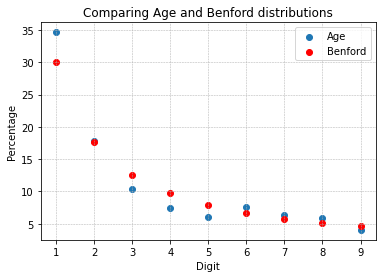

RMSE:  0.07858886306725872 




In [63]:
Benford_print(df_body['Age'], 'Age')